<a href="https://colab.research.google.com/github/hypro2/step-by-step-multimodal/blob/main/multimodal_training_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up environment and importing libraries

In this segment, we install the libraries required and set up the environment to train the models. Please choose a GPU runtime in the Google Colab setting. It is also recommended to mount your Google Drive to the notebook so that the static files just need to be downloaded once and can be reused should you need to restart your runtime.

In [ ]:
# install required libraries
!pip install transformers timm

In [2]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd

Common configurations to be used throughout the notebook

In [3]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# set random seeds for repeatability
import numpy as np
import random

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [5]:
seed_val = 0
set_seed(seed_val)

## Data loading and training parameters

This segment downloads the data which we are going to use for the tutorial and defines the paths to read data from, as well as training parameters which we are going to use for all three models.

In [6]:
# HOME_FOLDER = '/content/drive/MyDrive/KDD/' # if mounted
HOME_FOLDER = '/content/KDD/' # if not mounted
WEBVISION_DATA_FOLDER = HOME_FOLDER + 'webvision_data/'
IMAGE_FOLDER = WEBVISION_DATA_FOLDER + 'images/'
RESULTS_FOLDER = HOME_FOLDER + 'results/'
TRAINED_MODELS_FOLDER = HOME_FOLDER + 'trained_models/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [ ]:
!mkdir -p $WEBVISION_DATA_FOLDER
!wget "https://drive.google.com/uc?id=1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm&export=download" -O $WEBVISION_DATA_FOLDER/data.zip
!unzip $WEBVISION_DATA_FOLDER/data.zip -d $WEBVISION_DATA_FOLDER

In [8]:
df_train = pd.read_csv(WEBVISION_DATA_FOLDER + 'train.csv')
df_test = pd.read_csv(WEBVISION_DATA_FOLDER + 'test.csv')

Exceute the cells below to see a random label, text, image triplet from the train dataset

In [9]:
import matplotlib.pyplot as plt

def show_sample(row_num):
    sample_row = df_train.iloc[row_num]
    print('Index:', row_num)
    print('Label:', sample_row['label'])
    print('Text:', sample_row['text'])
    image_path = IMAGE_FOLDER + sample_row['img_path']
    im = Image.open(image_path)
    plt.imshow(im)

Index: 394
Label: bookshop
Text: The highest forms of literature were to be found on the English bookstall. Perhaps these should be in the Self-Help section .


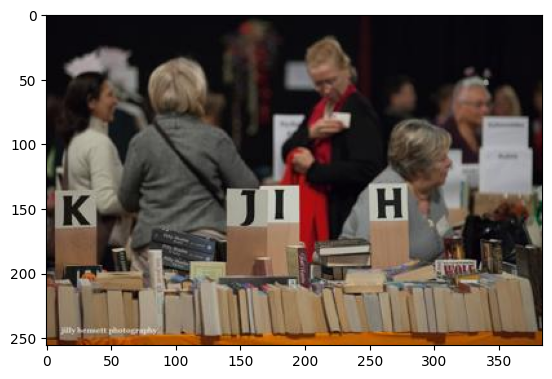

In [10]:
from random import randint
show_sample(randint(0, len(df_train)))

We create the mapping table to map the string labels to integers to be used for the class labels and vice versa.

In [11]:
label_to_id = {lab:i for i, lab in enumerate(df_train['label'].sort_values().unique())}
id_to_label = {v:k for k,v in label_to_id.items()}

In [12]:
label_to_id

{'bookshop': 0,
 'breakwater': 1,
 'chiton': 2,
 'coil': 3,
 'confectionery': 4,
 'gar': 5,
 'gasmask': 6,
 'polecat': 7,
 'seashore': 8,
 'streetcar': 9}

In [13]:
num_out_labels = len(label_to_id)

In [14]:
## training parameters to be used for all models ##
num_train_epochs = 5
batch_size = 16
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

## BERT
The first model which we are going to train is a BERT model which only uses the text from the data.

### Dataset
Since we are training a text only model, the dataset which we fit into the model only requires two attributes: **text** and **label**.

In [15]:
class TextDataset(Dataset):
    def __init__(self, df, label_to_id, text_field="text", label_field="label"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.text_field = text_field
        self.label_field = label_field

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]

        return text, label

    def __len__(self):
        return self.df.shape[0]

### Model
The model uses BERT to encode the text, and feeds the encodings (a 768 dimension vector) into a fully connected linear layer with 10 outputs (one for each class label).
이 모델은 BERT를 사용하여 텍스트를 인코딩하고, 인코딩(768차원 벡터)을 10개의 출력(각 클래스 레이블에 하나씩)이 있는 완전히 연결된 선형 레이어에 공급합니다.

![](https://drive.google.com/uc?export=view&id=1nlBu9P8saotjNg_nv_tfdnTxpxaFAhqq)

In [16]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
class VLBertModel(nn.Module):

    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.classifier = nn.Linear(self.text_encoder.config.hidden_size, num_labels)


    def forward(self, text):
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True)
        logits = self.classifier(output.last_hidden_state[:, 0, :]) # CLS embedding
        return logits

In [18]:
# create the model
bert_model = VLBertModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
bert_model = bert_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
bert_model

VLBertModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

### Training
Load the data using the text dataset, feed it into a data loader for random sampling, and train the model

In [20]:
set_seed(seed_val)

train_dataset = TextDataset(df=df_train, label_to_id=label_to_id, text_field='text', label_field='label')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(bert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

bert_model.train()


start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        bert_model.zero_grad()
        b_logits = bert_model(text=b_inputs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

end = perf_counter()
bert_training_time = end- start
print('Training completed in ', bert_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 108.7802220582962
    avg_epoch_loss = 2.175604441165924
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 76.00955700874329
    avg_epoch_loss = 1.5201911401748658
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 50.48360651731491
    avg_epoch_loss = 1.0096721303462983
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 41.306284725666046
    avg_epoch_loss = 0.826125694513321
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 38.860495030879974
    avg_epoch_loss = 0.7772099006175995
    learning rate = 0.0
Training completed in  36.21053210399998 seconds


### Testing
Predict on the test set

In [21]:
bert_prediction_results = []

test_dataset = TextDataset(df=df_test, label_to_id=label_to_id, text_field='text', label_field='label')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  bert_model.eval()

  b_text, b_labels = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = bert_model(text=b_inputs)
      b_logits = b_logits.detach().cpu()

  bert_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

bert_prediction_labels = [id_to_label[p] for p in bert_prediction_results]

  0%|          | 0/13 [00:00<?, ?it/s]

Generate the classification report by comparing the predictions from the model with the true labels

In [22]:
bert_class_report = classification_report(df_test['label'], bert_prediction_labels, output_dict=True)
bert_class_report['training_time (seconds)'] = bert_training_time

with open(RESULTS_FOLDER + 'bert_class_report.json', 'w') as f:
  json.dump(bert_class_report, f)

print(bert_class_report['accuracy'])

0.82


In [ ]:
# while True:pass

## BERT + ResNet-50
The next model that we are training uses a combination of BERT and ResNet-50 to encode the text and images, respectively.

### Dataset
Unlike the previous Dataset used for BERT, we include images in this dataset by reading the image files and applying a series of transformations to them so that they can fit into the ResNet model.

In [23]:
class ResNetDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])


    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


        image = Image.open(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

### Model
원래 ResNet 모델은 마지막에 1000개의 클래스가 있는 완전 연결 레이어로 구성되어 해당 클래스에 속하는 각 이미지의 점수를 표시합니다. 그러나 우리의 출력 클래스는 다르며 1000개의 클래스 출력 확률 대신 완전 연결 레이어 이전의 이미지 특징을 사용하고자 합니다. 따라서 완전히 연결된 계층을 제외하여 원래 ResNet 모델 아키텍처에서 이 모델을 "추출"합니다.

그런 다음 추출한 ResNet 모델을 BERT 모델과 쌍을 이루고 그 위에 이전 BERT 분류기에서 했던 것처럼 10개의 클래스 선형 레이어를 추가합니다.

![](https://drive.google.com/uc?export=view&id=1vFL3V1LdRlamLjkoI7ieoimxbwGnR7mU)


ResNet-50 모델은 이미지를 1000개의 클래스로 분류하기 위해 이미지넷 데이터로 학습되므로 마지막 레이어는 1000개의 출력 노드가 완전히 연결된 레이어입니다. 출력 클래스가 다르기 때문에 이 출력은 우리에게 유용하지 않습니다. 따라서 이 완전히 연결된 레이어를 제거하고 마지막 평균 풀링 레이어 이후의 기능을 사용해야 합니다. 이 작업은 레이어와 가중치를 다른 네트워크에 복사하고 마지막 레이어를 제외하면 됩니다.

![](https://drive.google.com/uc?export=view&id=1ivYlubrhvY00P7b2SYLfpRSF3XxJUbfh)

In [24]:
# extract layers of resnet-50 to build a new model

import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)


    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [25]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [26]:
# last output layer name for resnet is named 'layer4', dim 2048*7*7
# last layer name before fc is named 'avgpool', dim 2048*1*1 -> needs to be flattened
# reference: https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b

class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048

        self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)

    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        img_feature = self.visual_encoder(image)
        features = torch.cat((text_feature, img_feature), 1)

        logits = self.classifier(features)

        return logits

In [27]:
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]


In [28]:
resnet_model

BertResNetModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

### Training
Similar to BERT training, but we take in images as an additional input

In [29]:
## training loop
set_seed(seed_val)

train_dataset = ResNetDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

resnet_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()
        b_logits = resnet_model(text=b_inputs, image=b_imgs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
resnet_training_time = end- start
print('Training completed in ', resnet_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 106.57862913608551
    avg_epoch_loss = 2.1315725827217102
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 76.43803322315216
    avg_epoch_loss = 1.5287606644630432
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 55.025320291519165
    avg_epoch_loss = 1.1005064058303833
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 45.50879293680191
    avg_epoch_loss = 0.9101758587360382
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 42.89364868402481
    avg_epoch_loss = 0.8578729736804962
    learning rate = 0.0
Training completed in  80.433109382 seconds


### Testing

In [30]:
# testing loop

resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  resnet_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = resnet_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()

  resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

resnet_prediction_labels = [id_to_label[p] for p in resnet_prediction_results]

  0%|          | 0/13 [00:00<?, ?it/s]

Generate the classification report

In [31]:
resnet_class_report = classification_report(df_test['label'], resnet_prediction_labels, output_dict=True)
resnet_class_report['training_time (seconds)'] = resnet_training_time

with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
  json.dump(resnet_class_report, f)

print(resnet_class_report['accuracy'])

0.795
